First we try to understand which is the best SVM classifier among Linear, 2nd degree polynomial, radial basis function and their angularized versions, each of which tested with the following set of Cs: 0.3, 0.7, 1.0, 25.0, 50.0, 75.0, 100.0. 

In [1]:
import numpy as np
from svm_classifier import svm_with_different_Cs, angular_svm_with_different_Cs
from knn_classifier import k_nn
from time import time
import pandas as pd
from ctypes import *
from math import sqrt as sqrt
from sys import float_info
import cpuinfo

if "Intel" in cpuinfo.get_cpu_info()["brand_raw"]:
    from sklearnex import patch_sklearn

    patch_sklearn()

lib = cdll.LoadLibrary("./lib_naive_.so")


class cross_validation_result(Structure):
    _fields_ = [    ("avg_accuracy", c_float),
                    ("min_accuracy", c_float),
                    ("max_accuracy", c_float),
                    ("accuracy_variance", c_float) ]
    def __init__(self):
        self.avg_accuracy = self.accuracy_variance = 0;
        self.min_accuracy = float_info.max;
        self.max_accuracy = float_info.min;
    
    def print_scores(self):
        print( "==========================================================" + "\n" 
                + "Naive bayes classification: " + "\n" 
                + "Minimum Accuracy: " + str(self.min_accuracy) + "\n"
                + "Average Accuracy: " + str(self.avg_accuracy) + "\n"
                + "Maximum Accuracy: " + str(self.max_accuracy) + "\n"
                + "Variance of Accuracy: " + str(self.accuracy_variance) + "\n"
                + "Standard Deviation of Accuracy: " + str(sqrt(self.accuracy_variance)) + "\n" 
                + "=========================================================="
        )



# Load spambase dataset
file_name = "spambase.data"
data = open(file_name, "r")
mailData = np.loadtxt(data, delimiter=",")


# Naive Bayes
lib.py_main.restype = cross_validation_result
start = time()
naive_bayes_score = lib.py_main()
naive_bayes_time = time() - start

# SVMs
start = time()
svm_scores = svm_with_different_Cs(mailData)
svm_time = time() - start

# Norm SVMs
start = time()
svm_scores = svm_scores + angular_svm_with_different_Cs(mailData)
svm_norm_time = time() - start

# K-NN
start = time()
knn_score = k_nn(mailData)
knn_time = time() - start

min_accuracy = []
avg_accuracy = []
max_accuracy = []
support_vectors_numbers = []
elapsed_time = []
var_of_accuracy = []
std_of_accuracy = []
svm_Cs = []
index = []
for score in svm_scores:
    min_accuracy.append(round(score[0].min() * 100, 4))
    avg_accuracy.append(round(score[0].mean() * 100, 4)) 
    max_accuracy.append(round(score[0].max() * 100, 4)) 
    support_vectors_numbers.append(score[1])
    elapsed_time.append(round(score[2], 4))
    var_of_accuracy.append(score[0].var())
    std_of_accuracy.append(score[0].std())
    svm_Cs.append(score[4])
    index.append(score[3])


svm_table = pd.DataFrame(
    {
        "C" : svm_Cs,
        "Minimum Accuracy": min_accuracy,
        "Average Accuracy": avg_accuracy,
        "Maximum Accuracy": max_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
        "Number of vectors" : support_vectors_numbers
    },
    index=index
)

svm_table.sort_values(by=['Average Accuracy'])



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


,C,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time,Number of vectors
Linear SVC,0.3,60.4348,60.6825,60.8696,0.000002,0.001404,1.0663,"[1301, 1300]"
Linear SVC,0.7,60.4348,60.7260,61.0870,0.000003,0.001846,1.0922,"[1300, 1298]"
Linear SVC,1.0,60.5206,60.8129,61.0870,0.000002,0.001521,1.1288,"[1299, 1297]"
2-degree Poly SVC,0.3,71.0870,72.9839,75.2174,0.000169,0.012987,2.1571,"[1236, 1223]"
2-degree Poly SVC,0.7,76.9565,79.5260,81.9565,0.000244,0.015605,2.2539,"[1145, 1134]"
2-degree Poly SVC,1.0,79.5652,81.1564,84.3478,0.000207,0.014375,2.2539,"[1095, 1087]"
Linear SVC,25.0,85.0000,87.1548,88.4783,0.000093,0.009622,1.0513,"[1091, 1089]"
Linear SVC,50.0,86.0870,88.8067,90.0000,0.000109,0.010449,1.1209,"[918, 918]"
Linear SVC,75.0,87.8261,89.6327,90.4348,0.000059,0.007663,1.1404,"[830, 833]"
2-degree Poly SVC,25.0,88.6957,89.7627,91.5401,0.000070,0.008371,2.1821,"[632, 604]"


As we can see, the angularised versions of SVM usually perform much better in terms of accuracy, number of support vectors and execution time. If you run it several times you will get different results each time due to the shuffling of the dataset, but usually the two best classifiers in terms of quoted performance are the Normalized RBF SVM and the Normalized 2nd-degree SVM (usually the Polynomial is much better in terms of execution time). For simplicity we will take the one that gives the best average accuracy at runtime.

So, we can now make a similar comparison between the "best" SVM and all other classifiers.

In [2]:
result = svm_table.iloc[-1]
minimum_accuracy = [
    result['Minimum Accuracy'],
    knn_score.min() * 100,
    naive_bayes_score.min_accuracy * 100 
]
average_accuracy = [
    result['Average Accuracy'],
    knn_score.mean() * 100,
    naive_bayes_score.avg_accuracy * 100
]
maximum_accuracy = [
    result['Maximum Accuracy'],
    knn_score.max() * 100,
    naive_bayes_score.max_accuracy * 100 
]
elapsed_time = [
    result['Elapsed time'],
    knn_time,
    naive_bayes_time
]
var_of_accuracy = [
    result['Variance of Accuracy'],
    knn_score.var(),
    naive_bayes_score.accuracy_variance
]
std_of_accuracy = [
    result['Standard deviation of Accuracy'],
    knn_score.std(),
    sqrt(naive_bayes_score.accuracy_variance)
]
index = [
    result.name,
    "K-NN",
    "Naive Bayes"
]
df_for_table = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
        "Variance of Accuracy": var_of_accuracy,
        "Standard deviation of Accuracy": std_of_accuracy,
        "Elapsed time": elapsed_time,
    },
    index=index
)

df_for_table.sort_values(by=['Average Accuracy'])

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Variance of Accuracy,Standard deviation of Accuracy,Elapsed time
Naive Bayes,81.699347,83.968174,86.710238,0.003071,0.055420,0.048617
K-NN,88.260870,90.827690,92.624729,0.000130,0.011396,0.049740
Norm RBF SVC,92.841600,94.458100,96.521700,0.000156,0.012477,10.471100


And we look at these results from a graphical point of view.

(0.0, 100.0)

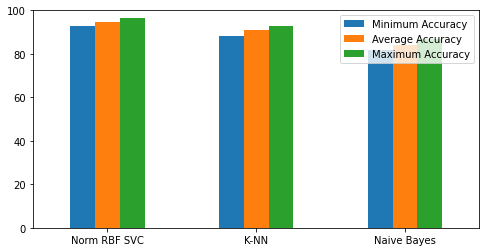

In [3]:
df = pd.DataFrame(
    {
        "Minimum Accuracy": minimum_accuracy,
        "Average Accuracy": average_accuracy,
        "Maximum Accuracy": maximum_accuracy,
    },
    index=index
)

ax = df.plot.bar(rot=0, figsize=(8, 4))
ax.set_ylim(0, 100)


Clearly, the SVM classifier outperforms all classifiers in terms of accuracy (obviously at the cost of a higher execution time).